# CAP 6619 - Deep Learning
## Dr Marques
## Project 4
## Sequential data (timeseries + text)

Total number of points: 100 (+ 15 optional bonus points), as indicated.


Aneesha Vangavolu (Z23692557)

Sai Jhansi Kongara (Z23689565)

Shweta Ayyalasomayajula (Z23690653)

https://colab.research.google.com/drive/1I4-D8IbXXA4LBzhjq5FHpQ6ofbruzzbL?usp=sharing&authuser=1#scrollTo=jt5F8KualDCD

*Expand all notebook bocks/sections and ensure code has properly executed, save as pdf(above left menu) when completed to submit to Canvas.*

*To save a pdf version: Click the File menu above, print, destination: change to save as pdf., print, choose destination folder for your pdf.*

##### **Cite your sources** *(OPTIONAL if none used beyond those above)*

Add your own sources and references here.

## **Part 1: Temperature forecasting using RNNs**

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

**Useful sources and references for Part 1:**

> Indented block



https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### **Acquiring and inspecting the data**

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-09-17 19:26:39--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.36.8, 52.216.145.45, 52.216.147.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.36.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.25MB/s    in 2.5s    

2023-09-17 19:26:42 (5.25 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

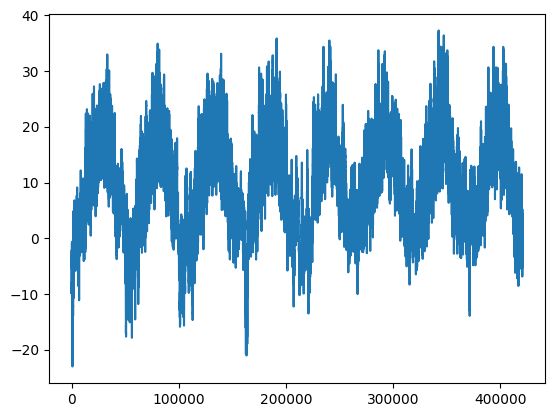

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

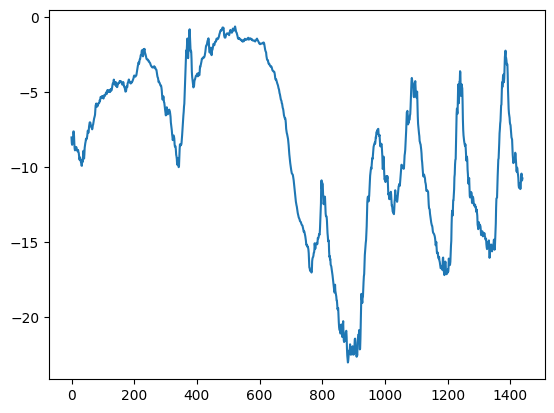

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **Building a baseline "model"**

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### **Building our *real* first model**

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 66ms/step - loss: 44.8064 - mae: 4.8771 - val_loss: 12.8423 - val_mae: 2.7152
Epoch 2/10
819/819 [==============================] - 53s 64ms/step - loss: 11.0029 - mae: 2.5731 - val_loss: 9.6743 - val_mae: 2.4037
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.6088 - mae: 2.4199 - val_loss: 9.6692 - val_mae: 2.4058
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.2550 - mae: 2.3735 - val_loss: 9.6768 - val_mae: 2.4054
Epoch 5/10
819/819 [==============================] - 53s 65ms/step - loss: 8.9974 - mae: 2.3374 - val_loss: 10.2456 - val_mae: 2.4763
Epoch 6/10
819/819 [==============================] - 53s 64ms/step - loss: 8.8023 - mae: 2.3069 - val_loss: 9.7199 - val_mae: 2.4109
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.6574 - mae: 2.2860 - val_loss: 9.9150 - val_mae: 2.4328
Epoch 8/10
819/819 [==============================] - 45s 

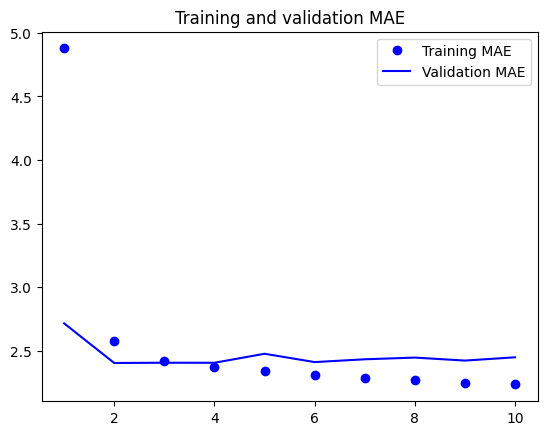

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **PART 1** - <font color='red'>*Your Turn*</font>

### **Part 1 - Tasks:** *(list of deliverables)*

**1.1  &emsp;<font color='red'>(*required*)</font>  &emsp;Improve the solution for temperature forecast**

 &emsp; **Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., has a lower Test MAE.**
<br>

 >  *You can use a (combination of) different architecture (e.g., bidirectional RNN, see Listing 10.24 in the textbook), dropout and/or other regularization strategies, hyperparameter optimizations, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **1.2  &emsp;<font color='red'>(*required*)</font> &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test MAE values and other contents with your own!**

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.61| Slightly better than baseline |
| *Improved* model / variation of your choice | 2.57| Best overall, still shows signs of overfitting |




#### **Part 1 - Required Tasks:**   *(responses & code)*

##### **1.1 Improve the solution for temperature forecast**

 Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., have a lower Test MAE.

###### **1.1.1 Your solution** &emsp; <font color='red'>*(bidirectional_lstm Model)*</font > [40 points]

In [ ]:

# Your code here and in additional cells as needed
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_bidirectional_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
819/819 [==============================] - 54s 61ms/step - loss: 27.2613 - mae: 3.7361 - val_loss: 10.0643 - val_mae: 2.4632
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 9.6500 - mae: 2.4282 - val_loss: 9.6913 - val_mae: 2.4104
Epoch 3/10
819/819 [==============================] - 63s 77ms/step - loss: 8.7530 - mae: 2.3077 - val_loss: 10.0419 - val_mae: 2.4382
Epoch 4/10
819/819 [==============================] - 52s 64ms/step - loss: 8.2608 - mae: 2.2427 - val_loss: 9.8466 - val_mae: 2.4196
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 7.8497 - mae: 2.1873 - val_loss: 10.0809 - val_mae: 2.4512
Epoch 6/10
819/819 [==============================] - 59s 71ms/step - loss: 7.4787 - mae: 2.1355 - val_loss: 10.2096 - val_mae: 2.4584
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.2098 - mae: 2.0966 - val_loss: 10.0902 - val_mae: 2.4513
Epoch 8/10
819/819 [==============================] - 49

##### **1.2 Summary Table**

 **Replace the Test MAE values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.61| Slightly better than baseline |
| *Improved* model / variation of your choice | 2.57| Best overall, still shows signs of overfitting |

## **Part 2: Sentiment analysis using LSTMs**

> In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

> Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

>  The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


**Useful sources and references for Part 2:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### **Imports + auxiliary function**

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Import `matplotlib` and create a helper function to plot graphs:**

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**


> The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

> Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Initially this returns a dataset of (text, label pairs):**

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Next shuffle the data for training and create batches of these `(text, label)` pairs:**

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Every now and then a movie advertises itself as scary or frightening, though they usually aren\'t. Most modern horror movies fit into this category.<br /><br />Then there are those movies that don\'t simply cause the tension and adrenaline to pump through your veins harder than usual. They actually frighten you to a level that you\'ve never experienced.<br /><br />"Halloween" is such a film. It takes so many risks that would make most movie producers cringe. But nearly all of them work. "Halloween" is awe-inspiring in its simplicity, and terrifying as a whole.<br /><br />The story is simple. Laurie Strode (Jamie Lee Curtis) is babysitting some kids on Halloween night, while a madman is on the loose after escaping from a mental institution after brutally murdering his older sister 15 years ago. Of course, the madman, later known as Michael Myers, begins killing the local teenage population, and eventually he comes after Laurie.<br /><br />Sounds familiar, right? Just another 

### **Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

**Create the layer, and pass the dataset's text to the layer's `.adapt` method:**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: **

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):**

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[168, 150,   3, ...,   0,   0,   0],
       [ 10, 284,  11, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0]])

**With the default settings, the process is not completely reversible. There are three main reasons for that:**

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Every now and then a movie advertises itself as scary or frightening, though they usually aren\'t. Most modern horror movies fit into this category.<br /><br />Then there are those movies that don\'t simply cause the tension and adrenaline to pump through your veins harder than usual. They actually frighten you to a level that you\'ve never experienced.<br /><br />"Halloween" is such a film. It takes so many risks that would make most movie producers cringe. But nearly all of them work. "Halloween" is awe-inspiring in its simplicity, and terrifying as a whole.<br /><br />The story is simple. Laurie Strode (Jamie Lee Curtis) is babysitting some kids on Halloween night, while a madman is on the loose after escaping from a mental institution after brutally murdering his older sister 15 years ago. Of course, the madman, later known as Michael Myers, begins killing the local teenage population, and eventually he comes after Laurie.<br /><br />Sounds familiar, right? Just anothe

### **Create the first model**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:**

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00464672]


 **Now, evaluate it again in a batch with a longer sentence. The result should be identical:**

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 68ms/step
[-0.00464672]


**Compile the Keras model to configure the training process:**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 58s 124ms/step - loss: 0.6321 - accuracy: 0.5696 - val_loss: 0.4916 - val_accuracy: 0.8036
Epoch 2/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3812 - accuracy: 0.8251 - val_loss: 0.3515 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3335 - accuracy: 0.8531 - val_loss: 0.3337 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3179 - accuracy: 0.8615 - val_loss: 0.3388 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3125 - accuracy: 0.8647 - val_loss: 0.3273 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3090 - accuracy: 0.8676 - val_loss: 0.3266 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3031 - accuracy: 0.8688 - val_loss: 0.3272 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3180 - accuracy: 0.8611
Test Loss: 0.31803661584854126
Test Accuracy: 0.8611199855804443


(0.0, 0.6488342270255089)

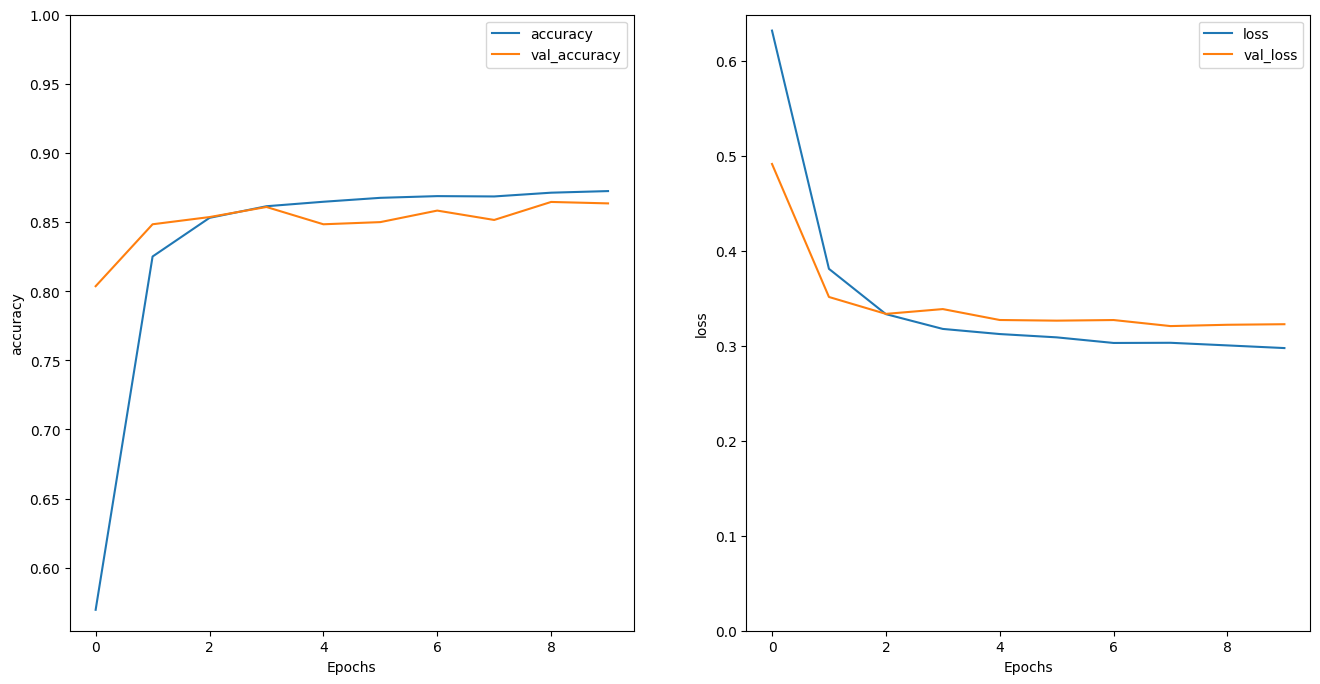

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Run a prediction on a new sentence:**

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### **Second model: stacking two LSTM layers**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

**The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 85s 173ms/step - loss: 0.6295 - accuracy: 0.5811 - val_loss: 0.4179 - val_accuracy: 0.8271
Epoch 2/10
391/391 [==============================] - 50s 126ms/step - loss: 0.3921 - accuracy: 0.8267 - val_loss: 0.3550 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3380 - accuracy: 0.8570 - val_loss: 0.3517 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3194 - accuracy: 0.8639 - val_loss: 0.3329 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3128 - accuracy: 0.8690 - val_loss: 0.3207 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3043 - accuracy: 0.8694 - val_loss: 0.3195 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3042 - accuracy: 0.8696 - val_loss: 0.3234 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3158 - accuracy: 0.8593
Test Loss: 0.31583166122436523
Test Accuracy: 0.859279990196228


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

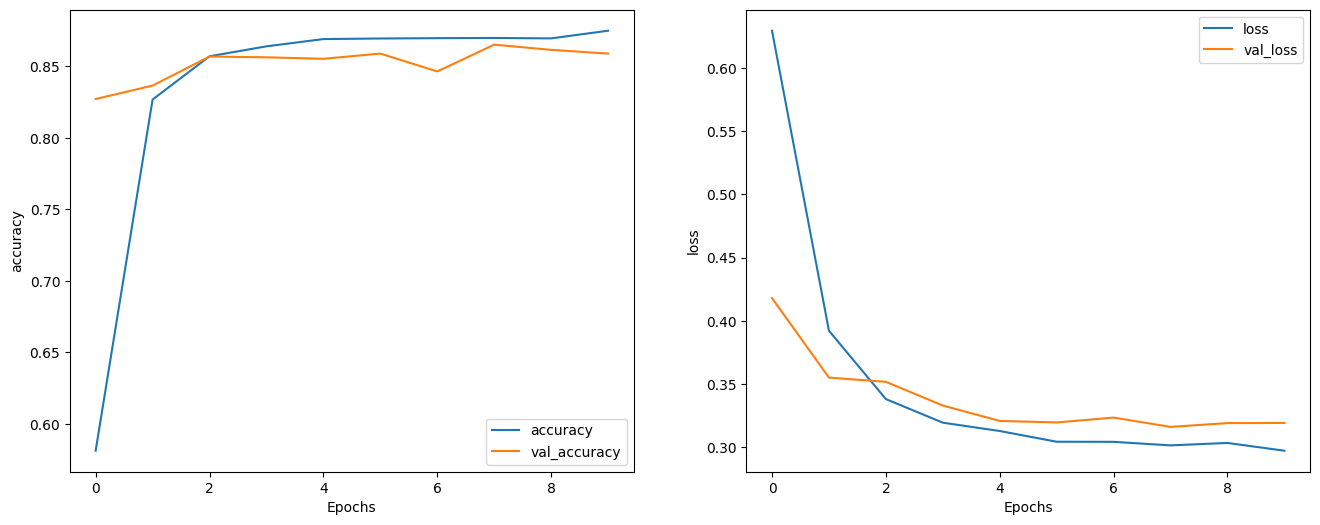

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **PART 2** - <font color='red'>*Your Turn*</font>

### **Part 2 - Tasks:** *(list of deliverables)*

**2.1  &emsp;<font color='red'>(*required*)</font>  &emsp;Improve the solution for IMDB sentiment analysis**
<br>

 >  Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

*You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **2.2  &emsp;<font color='red'>(*required*)</font> &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.851 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.915 | Best overall |





#### **Part 2 - Required Tasks:**   *(responses & code)*

##### **2.1 Improve the solution for IMDB sentiment analysis**

 Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

###### **2.1.1 Your solution** &emsp; <font color='red'>* imdb_reviews_sentiment_classifier*</font > [40 points]

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Define and adapt the encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Define the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True, input_length=1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    steps_per_epoch=len(train_dataset))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)









Epoch 1/10
782/782 [==============================] - 146s 159ms/step - loss: 0.5473 - accuracy: 0.7021 - val_loss: 0.3832 - val_accuracy: 0.8438
Epoch 2/10
782/782 [==============================] - 85s 108ms/step - loss: 0.3515 - accuracy: 0.8550 - val_loss: 0.3510 - val_accuracy: 0.8594
Epoch 3/10
782/782 [==============================] - 85s 109ms/step - loss: 0.3309 - accuracy: 0.8646 - val_loss: 0.3512 - val_accuracy: 0.8625
Epoch 4/10
782/782 [==============================] - 84s 108ms/step - loss: 0.3232 - accuracy: 0.8713 - val_loss: 0.3419 - val_accuracy: 0.8604
Epoch 5/10
782/782 [==============================] - 84s 107ms/step - loss: 0.3180 - accuracy: 0.8715 - val_loss: 0.3463 - val_accuracy: 0.8594
Epoch 6/10
782/782 [==============================] - 84s 107ms/step - loss: 0.3106 - accuracy: 0.8760 - val_loss: 0.3398 - val_accuracy: 0.8646
Epoch 7/10
782/782 [==============================] - 87s 111ms/step - loss: 0.3033 - accuracy: 0.8781 - val_loss: 0.3393 - val_a

##### **2.2 Summary Table**

 **Replace the Test Accuracy values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*


| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.861 | Baseline |
| Second model (LSTM) | 0.859 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.863 | Best overall |

## **Part 3: NLP using Transformers**

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


**Useful sources and references for Part 3:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### **Setup**

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('What are you doing now?', '[start] ¿Qué estás haciendo? [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### **The Transformer encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### **The Transformer decoder**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 114s 81ms/step - loss: 3.7929 - accuracy: 0.4404 - val_loss: 2.8705 - val_accuracy: 0.5381
Epoch 2/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.8478 - accuracy: 0.5505 - val_loss: 2.5293 - val_accuracy: 0.5899
Epoch 3/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.5544 - accuracy: 0.5939 - val_loss: 2.3831 - val_accuracy: 0.6161
Epoch 4/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.3956 - accuracy: 0.6197 - val_loss: 2.4465 - val_accuracy: 0.6061
Epoch 5/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2910 - accuracy: 0.6377 - val_loss: 2.3160 - val_accuracy: 0.6289
Epoch 6/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2214 - accuracy: 0.6506 - val_loss: 2.3102 - val_accuracy: 0.6370
Epoch 7/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.1689 - accuracy: 0.6620 - val_loss: 2.3003 

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

## **Part 4: IMDB sentiment analysis using Transformers (OPTIONAL)** [15 points]

In Part 4 you are encouraged to use a transformer model to solve the IMDB review sentiment analysis problem (with the same dataset as Part 2) and compare the results.


##### **4.1 Your solution** &emsp;

In [ ]:
# Your code here and in additional cells as needed
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Define and adapt the encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Define the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    steps_per_epoch=len(train_dataset))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLVQI37/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLVQI37/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLVQI37/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Epoch 1/10
782/782 [==============================] - 101s 107ms/step - loss: 0.6593 - accuracy: 0.6049 - val_loss: 0.5621 - val_accuracy: 0.7365
Epoch 2/10
782/782 [==============================] - 43s 55ms/step - loss: 0.4599 - accuracy: 0.7973 - val_loss: 0.4285 - val_accuracy: 0.8229
Epoch 3/10
782/782 [==============================] - 44s 56ms/step - loss: 0.3880 - accuracy: 0.8407 - val_loss: 0.3897 - val_accuracy: 0.8427
Epoch 4/10
782/782 [==============================] - 43s 55ms/step - loss: 0.3545 - accuracy: 0.8558 - val_loss: 0.3620 - val_accuracy: 0.8500
Epoch 5/10
782/782 [==============================] - 42s 54ms/step - loss: 0.3340 - accuracy: 0.8647 - val_loss: 0.3539 - val_accuracy: 0.8573
Epoch 6/10
782/782 [==============================] - 42s 54ms/step - loss: 0.3209 - accuracy: 0.8723 - val_loss: 0.3496 - val_accurac

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize and prepare the dataset
def preprocess(text, label):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='tf')
    return inputs, label

train_dataset = train_dataset.map(preprocess).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=model.compute_loss,
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


ModuleNotFoundError: ignored

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertModel

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the model architecture
def create_model():
    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32)
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32)
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    embeddings = bert_model(input_ids, attention_mask=attention_mask)[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
    return model

model = create_model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Tokenize and prepare the dataset
def preprocess(text, label):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='tf')
    return {'input_ids': inputs['input_ids'][0], 'attention_mask': inputs['attention_mask'][0]}, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Train the model
batch_size = 32
train_dataset = train_dataset.shuffle(10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


ModuleNotFoundError: ignored

In [ ]:
!pip install transformers
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import TFGPT2Model, GPT2Tokenizer

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Initialize the GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2Model.from_pretrained('gpt2')

# Tokenize and prepare the dataset
def preprocess(text, label):
    return text, label

train_dataset = train_dataset.map(preprocess).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)



All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Epoch 1/3


TypeError: ignored

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import TFGPT2Model, GPT2Tokenizer

# Load the IMDB movie review dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Initialize the GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2Model.from_pretrained('gpt2')

# Tokenize and prepare the dataset
def preprocess(text, label):
    inputs = tokenizer.batch_encode_plus(
        text.numpy().tolist(),
        padding='longest',
        truncation=True,
        max_length=512,
        return_tensors='tf'
    )
    return inputs, label

train_dataset = train_dataset.map(preprocess).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


AttributeError: ignored

## **Part 5: Conclusions -** *Your Turn* [20 points]



***(Things to think about)*** Reflect on the tasks completed and the results obtained. Why did your models yield the results that they did? What worked as expected, what did not? and why?  What parameters had an impact? Why do you think that is the case? Does the metric used to evaluate the model matter (Accuracy/MAE)? So many other things that can be considered in your conclusions.

If you had extra time available, what else would you do to gain further insights from this notebook?

**Write your conclusions here.**
The Conclusions drawn from this assignments are as follows :

We now know how to create models using recurrent neural networks.
developed an LSTM model for temperature forecasting that produces more precise results.
To enhance the model's performance, we applied strategies including boosting the embedding dimension, decreasing the LSTM units, utilizing a different architecture like Conv1D, including dropout layers, and adjusting the learning rate.
We discovered how to enhance the model's performance and how to train a model more quickly utilizing several techniques, like batching and other things.
I acquired the ability to create models for sentiment analysis prediction.
a working knowledge of embeddings, dropout layers, and dense layers learned about the Transformers architecture, how to use it, and how it aids with real-world NLP problem solving.
I now understand how Sentimental Analysis and Natural Processing may be done using Deep Learning Models.
learned how to reduce overfitting utilizing techniques including increasing the number of dropout layers, batch normalizing, and reducing model complexity, among others.
I have a thought on Transformer encoders and decoders.
learned several NLP techniques, such as vectorization and tokenization.
Recognized deep learning in relation to several activation functions, such as the sigmoid, softmax, and relu functions.